In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler, CSVLogger


In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
(raw_train, raw_test), metadata = tfds.load(
    'cifar10',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label
train = raw_train.map(format_example)
test = raw_test.map(format_example)

BATCH_SIZE = 32
train_batches = train.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteYRQ6DC/cifar10-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteYRQ6DC/cifar10-test.tfrecord
Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


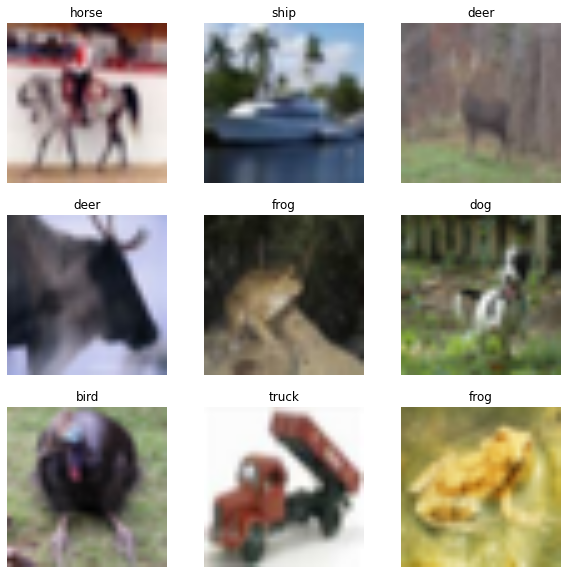

In [4]:
class_names = metadata.features['label'].int2str

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names(labels[i]))
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_batches.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_batches.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

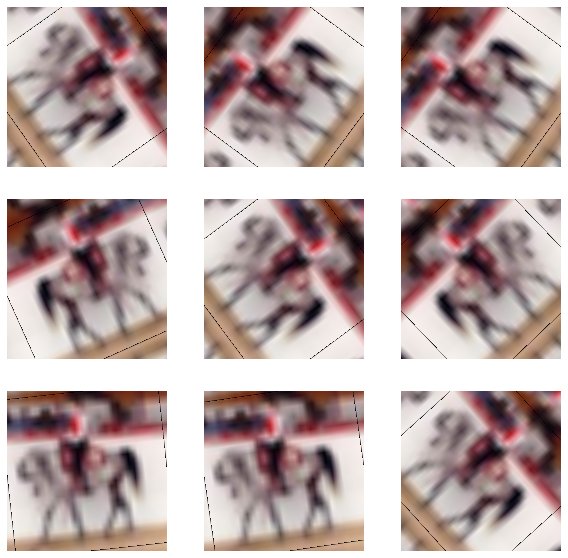

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (160,160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
flatten_layer = tf.keras.layers.Flatten()
flatten_batch = flatten_layer(feature_batch_average)
print(flatten_batch.shape)
dense_layer = tf.keras.layers.Dense(64)
dense_shape = dense_layer(flatten_batch)
print(dense_shape.shape)
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(dense_shape)
print(prediction_batch.shape)

(32, 5, 5, 1280)
(32, 1280)
(32, 1280)
(32, 64)
(32, 10)


In [10]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
# x = tf.keras.layers.Flatten
# x = tf.keras.layers.Dense(x, 64)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = flatten_layer(x)
x = dense_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

In [11]:
# base_learning_rate = 0.001
def decay_fn(epoch, lr):
    lr = 1e-4
    if epoch > 60:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 5e-2
    elif epoch > 10:
        lr *= 1e-1
    return lr
lr_scheduler = LearningRateScheduler(decay_fn)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
loss0, accuracy0 = model.evaluate(test_dataset)

313/313 [==============================] - 8s 26ms/step - loss: 3.7428 - accuracy: 0.0791


In [13]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=test_dataset,
                    callbacks=[lr_scheduler])

Epoch 1/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.4801 - accuracy: 0.4992 - val_loss: 0.7601 - val_accuracy: 0.7416
Epoch 2/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.0867 - accuracy: 0.6224 - val_loss: 0.6772 - val_accuracy: 0.7672
Epoch 3/10
1563/1563 [==============================] - 56s 36ms/step - loss: 1.0067 - accuracy: 0.6477 - val_loss: 0.6525 - val_accuracy: 0.7753
Epoch 4/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.9688 - accuracy: 0.6628 - val_loss: 0.6262 - val_accuracy: 0.7834
Epoch 5/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.9509 - accuracy: 0.6694 - val_loss: 0.6386 - val_accuracy: 0.7831
Epoch 6/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.9413 - accuracy: 0.6693 - val_loss: 0.6111 - val_accuracy: 0.7910
Epoch 7/10
1563/1563 [==============================] - 56s 36ms/step - loss: 0.9278 - accuracy: 0.6744 - val_loss: 0.6281 -

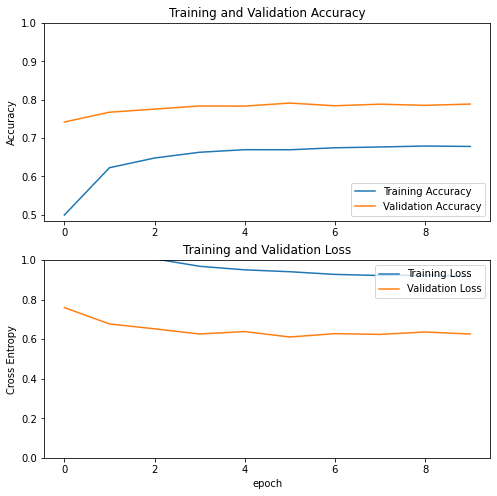

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=0.00001),
              metrics=['accuracy'])
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset)

Number of layers in the base model:  155
Epoch 10/20
1563/1563 [==============================] - 75s 48ms/step - loss: 0.4991 - accuracy: 0.8264 - val_loss: 0.3619 - val_accuracy: 0.8767
Epoch 11/20
1563/1563 [==============================] - 75s 48ms/step - loss: 0.4750 - accuracy: 0.8347 - val_loss: 0.3832 - val_accuracy: 0.8723
Epoch 12/20
1563/1563 [==============================] - 74s 47ms/step - loss: 0.4530 - accuracy: 0.8424 - val_loss: 0.3721 - val_accuracy: 0.8763
Epoch 13/20
1563/1563 [==============================] - 74s 47ms/step - loss: 0.4359 - accuracy: 0.8490 - val_loss: 0.3562 - val_accuracy: 0.8841
Epoch 14/20
1563/1563 [==============================] - 74s 47ms/step - loss: 0.4187 - accuracy: 0.8541 - val_loss: 0.3537 - val_accuracy: 0.8839
Epoch 15/20
1563/1563 [==============================] - 75s 48ms/step - loss: 0.4065 - accuracy: 0.8569 - val_loss: 0.3389 - val_accuracy: 0.8866
Epoch 16/20
1563/1563 [==============================] - 75s 48ms/step - loss